In [2]:
import os
from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.corpora import Dictionary
import enchant
enchantdict = enchant.Dict('en_US')

In [353]:
def preprocess(docs,no_below=20,no_above=0.7):
    # input is a an array of docs; each is one string
    tokenizer = RegexpTokenizer(r'\w+')
    for idx in range(len(docs)):
        docs[idx] = docs[idx].lower()  # Convert to lowercase.
        docs[idx] = tokenizer.tokenize(docs[idx])  # Split into words.

    # Remove numbers, but not words that contain numbers.
    docs = [[token for token in doc if not token.isnumeric()] for doc in docs]
    # Remove words that are less than three characters
    docs = [[token for token in doc if len(token) > 2] for doc in docs]   
    
    # Remove short words that are not in the dictionary
    docs = [[token for token in doc if len(token) > 4 or enchantdict.check(token)] for doc in docs]

    # Lemmatize all words in documents.
    lemmatizer = WordNetLemmatizer()
    docs = [[lemmatizer.lemmatize(token) for token in doc] for doc in docs]
    
    # Delete words based on their frequency in the whole corps
    # Create a dictionary representation of the documents.
    dictionary = Dictionary(docs)
    #set_trace()
    # Filter out words that occur less than 20 documents, or more than 70% of the documents.
    dictionary.filter_extremes(no_below, no_above)
    
    # According to the filtered dictionary, reconstruct the corpus
    corpus = [dictionary.doc2bow(doc) for doc in docs]
    
    return corpus, dictionary
    # TODO: linebreaks should be recovered into single word? search for solution first


In [2]:
years = list(range(22, 40))
dirs = ['text_data_new/volume_{}/'.format(y) for y in years]

In [3]:
ndocs = []
docs = []
import codecs


for d in dirs:
    fnames = os.listdir(d)
    # start with 1/10 of the data
    #fnames = [t[1] for t in enumerate(fnames) if t[0] % 10 == 0]
    for fn in fnames:
        with open(d + fn, 'r', encoding='utf-8') as f:
            fstring = ''
            for l in f.readlines():
                if np.mean([c.isalpha() for c in l]) > .7:
                    fstring = fstring + l
            docs.append(fstring)
    ndocs.append(len(fnames))

FileNotFoundError: [Errno 2] No such file or directory: 'text_data_new/volume_22/'

In [356]:
for i in range(len(docs)):
    docs[i] = docs[i].replace('-\n', '')

In [357]:
corpus, dictionary = preprocess(docs,no_below=36,no_above=0.5)

In [3]:

import logging
from gensim.models import ldaseqmodel
from gensim.models.wrappers.dtmmodel import DtmModel

from gensim.corpora import Dictionary, bleicorpus, textcorpus
import numpy as np
from gensim.matutils import hellinger
import time


In [ ]:
t0= time.time()
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

dtm_path = "/Users/alex/dtm/bin/dtm-darwin64"
model = DtmModel(dtm_path, corpus=corpus, time_slices=ndocs, num_topics=20, id2word=dictionary, initialize_lda=True)

dt = time.time() - t0


In [363]:
dt

7242.093078613281

In [44]:
#yeardata = []
#for t in range(len(ndocs)):
#    yeardata.append(model.dtm_vis(corpus, time=t))

In [365]:
doccutoffs = [0] + list(np.cumsum(ndocs))
term_topic = [None]
term_frequency = [None]
doc_topic, term_topic[0], doc_length, term_frequency[0], terms = model.dtm_vis(corpus[doccutoffs[0]:doccutoffs[1]], time=0)
_, _, doc_length, _, _ = model.dtm_vis(corpus, time=0)

for t in range(1, len(ndocs)):
    visdata = model.dtm_vis(corpus[doccutoffs[t]:doccutoffs[t+1]], time=t)
    term_topic.append(visdata[1])
    term_frequency.append(visdata[3])
    yeardata.append(visdata)

In [366]:
term_topic = np.array(term_topic)
term_frequency = np.array(term_frequency)

In [367]:
term_frequency.shape

(18, 9710)

In [423]:
alldata = {'term_topic': term_topic, # term_topic is n_years*n_topics*n_terms
          'doc_topic': doc_topic, # doc_topic is n_docs*n_topics
          'doc_length': doc_length, #doc_length is n_docs
          'term_frequency': term_frequency, #term_frequency is n_years*n_terms
          'terms': terms} #terms is n_terms

In [424]:
len(terms)

9710

In [4]:
import pickle


In [430]:
pickle.dump(alldata, open( "output/20topics_newpreprocess_dict.p", "wb" ))

In [5]:
alldata_new = pickle.load(open('output/20topics_newpreprocess_dict.p', 'rb'))

In [6]:
term_topic = alldata_new['term_topic']
doc_topic = alldata_new['doc_topic']
doc_length = alldata_new['doc_length']
term_frequency = alldata_new['term_frequency']
terms = alldata_new['terms']

In [7]:
from ggplot import *
import pandas as pd
% matplotlib inline

/Users/alex/anaconda/envs/wikiquote/lib/python3.6/site-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
/Users/alex/anaconda/envs/wikiquote/lib/python3.6/site-packages/ggplot/stats/smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp
/Users/alex/anaconda/envs/wikiquote/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


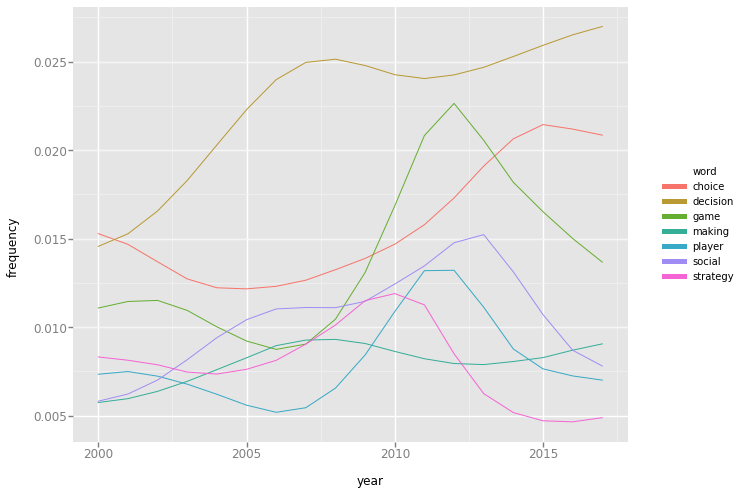

In [75]:
graphs = []
for topic_num in range(20):
    topic_np = term_topic[:,topic_num,:]
    topidx = np.argsort(-topic_np.sum(0))[:7]
    topic_np = topic_np[:,topidx]
    df = pd.DataFrame(topic_np, columns=np.array(terms)[topidx])
    df['year'] = range(2000, 2018)
    df = df.melt(id_vars=['year'], var_name='word', value_name='frequency')
    p = ggplot(aes(x='year', y='frequency', color='word'), data=df) + geom_line() + scale_x_continuous(breaks=[2000, 2005, 2010, 2015])
    p.save(filename='topic_graphs/topictopwords{}.png'.format(topic_num))
    graphs.append(ggplot(aes(x='year', y='frequency', color='word'), data=df) + geom_line() + scale_x_continuous(breaks=[2000, 2005, 2010, 2015]))

Topic Number: 0


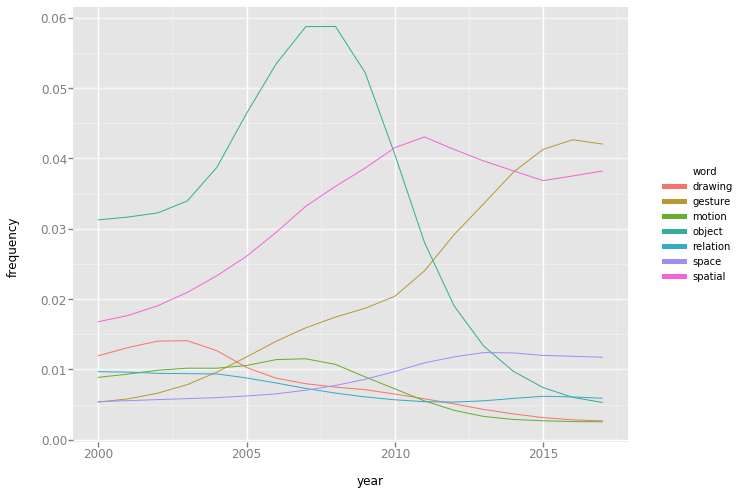

<ggplot: (-9223372036554797368)>
Topic Number: 1


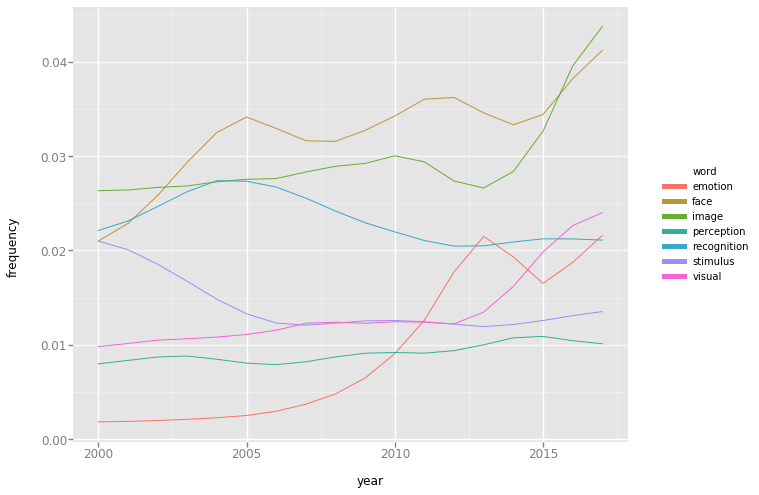

<ggplot: (-9223372036544014455)>
Topic Number: 2


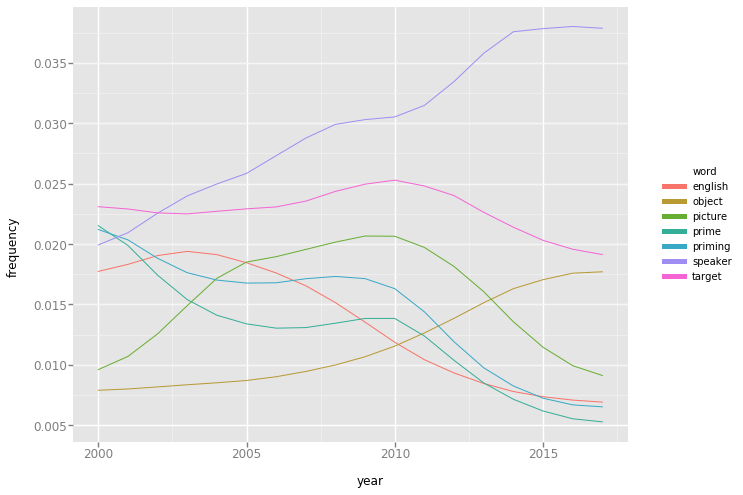

<ggplot: (307833762)>
Topic Number: 3


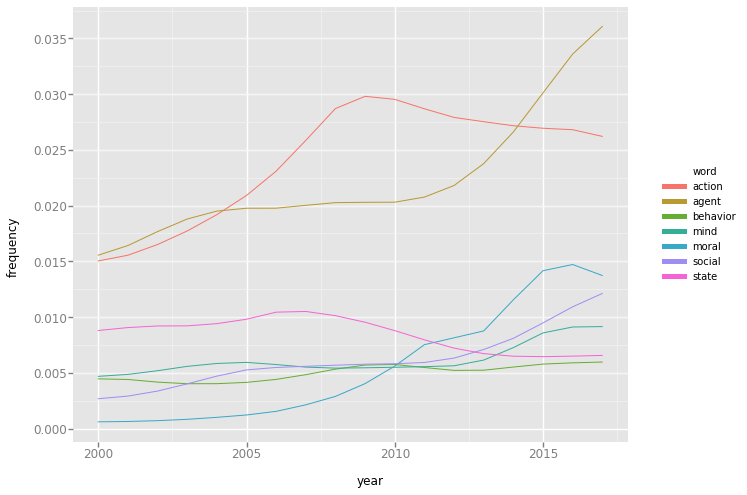

<ggplot: (-9223372036546940384)>
Topic Number: 4


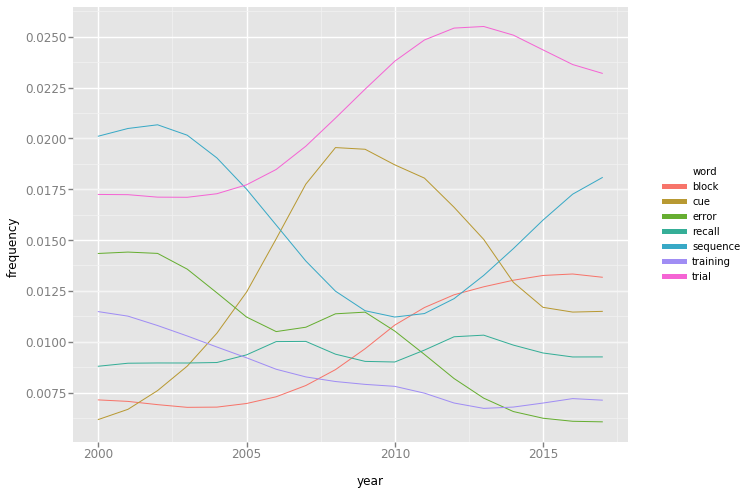

<ggplot: (312441990)>
Topic Number: 5


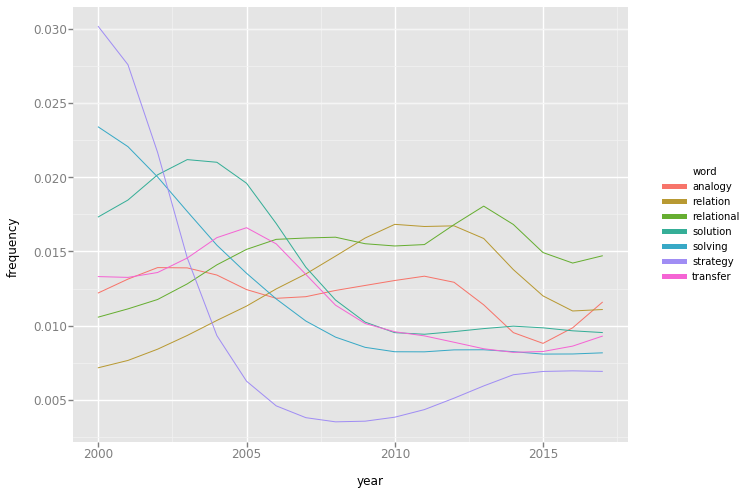

<ggplot: (312216566)>
Topic Number: 6


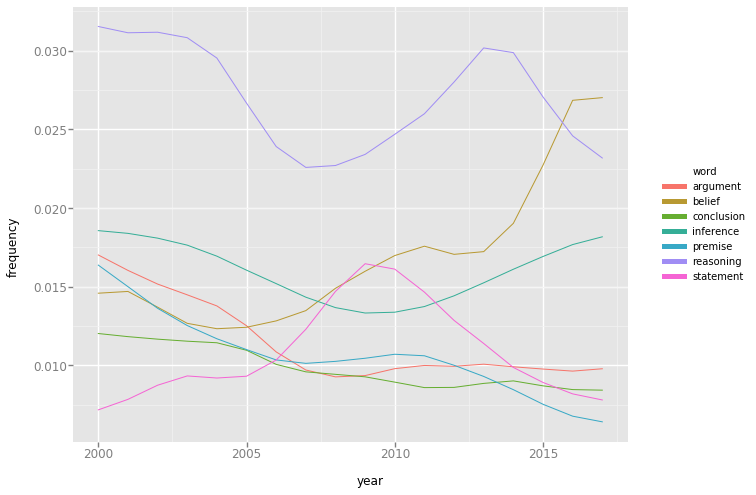

<ggplot: (-9223372036542559421)>
Topic Number: 7


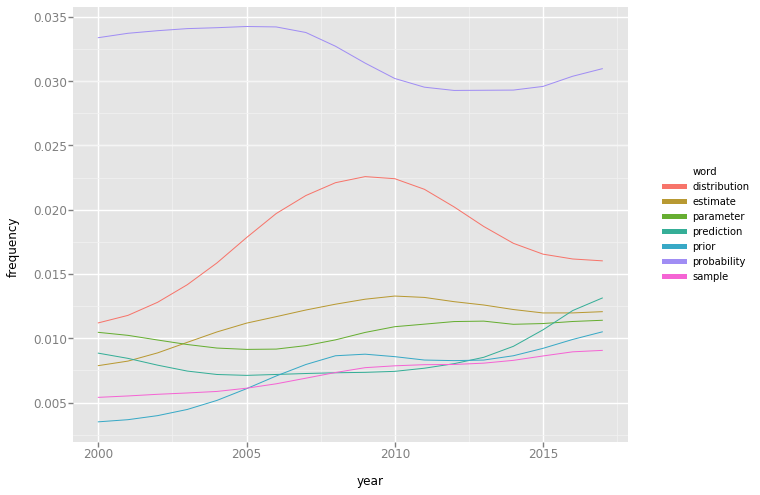

<ggplot: (-9223372036542920444)>
Topic Number: 8


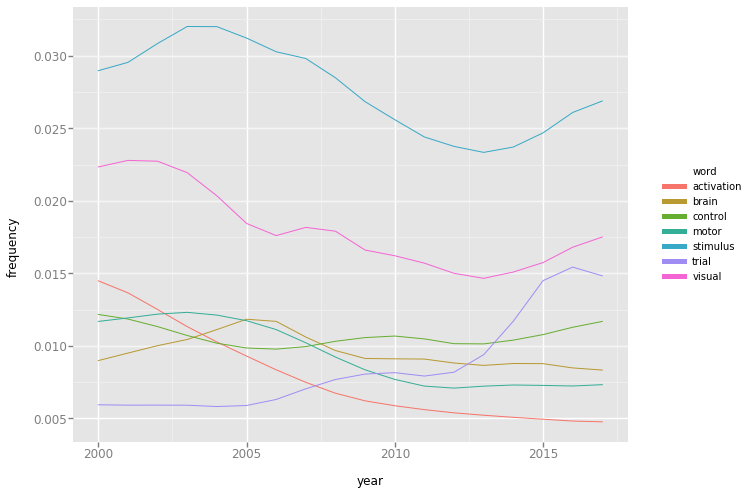

<ggplot: (312216454)>
Topic Number: 9


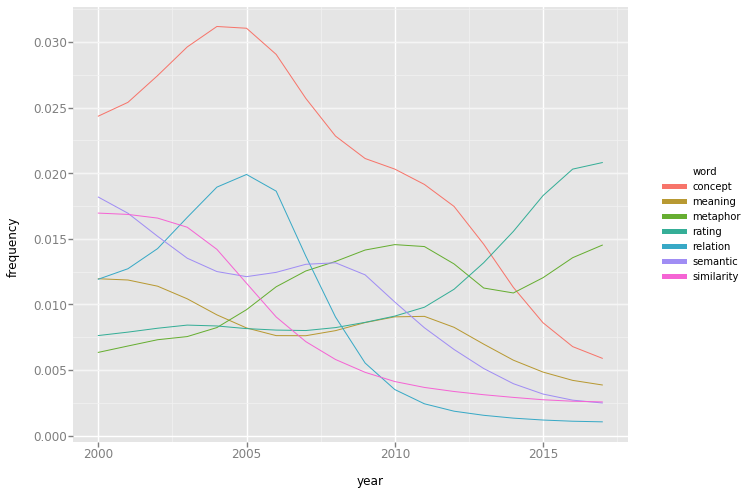

<ggplot: (312212442)>
Topic Number: 10


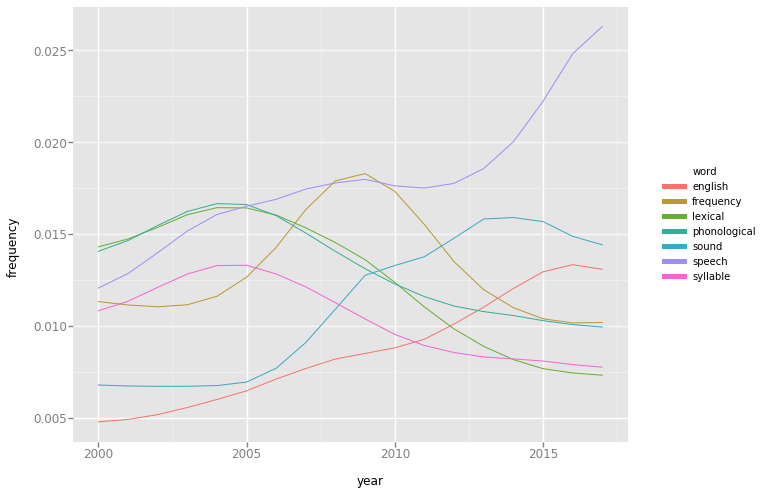

<ggplot: (-9223372036542563412)>
Topic Number: 11


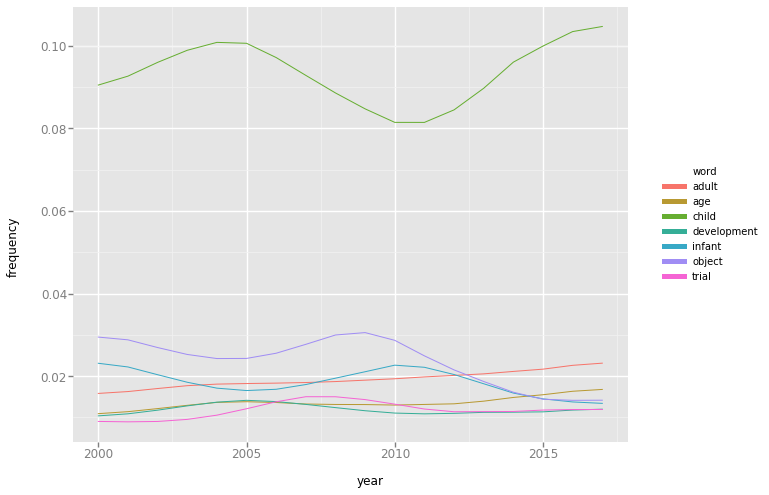

<ggplot: (312215830)>
Topic Number: 12


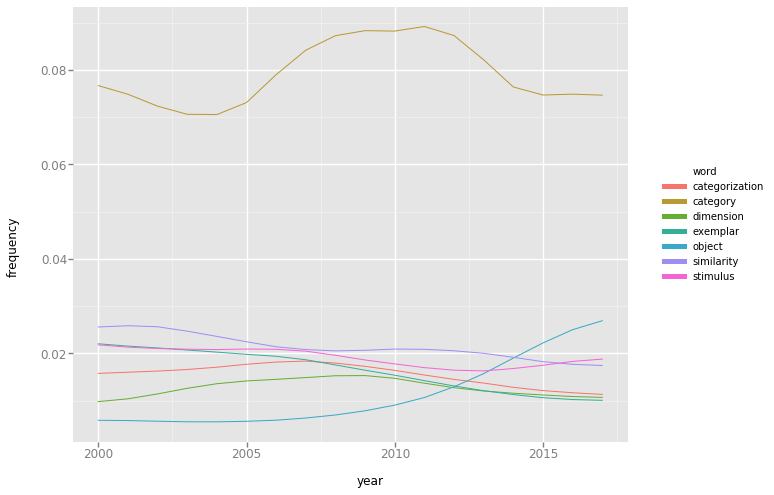

<ggplot: (-9223372036542559863)>
Topic Number: 13


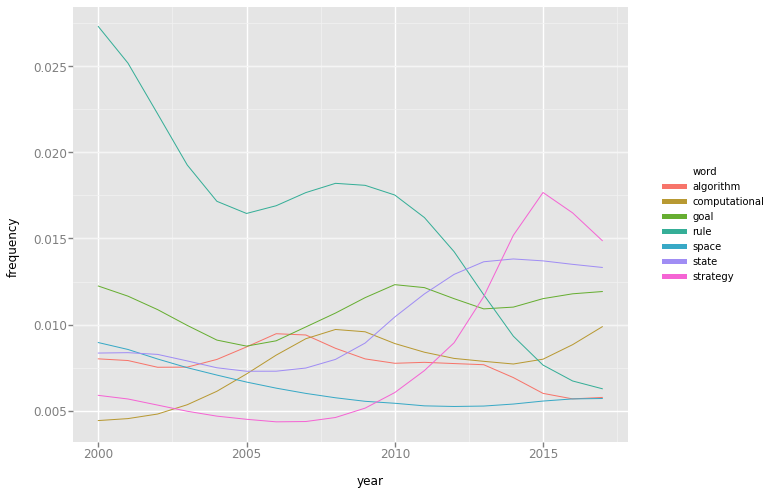

<ggplot: (-9223372036542559814)>
Topic Number: 14


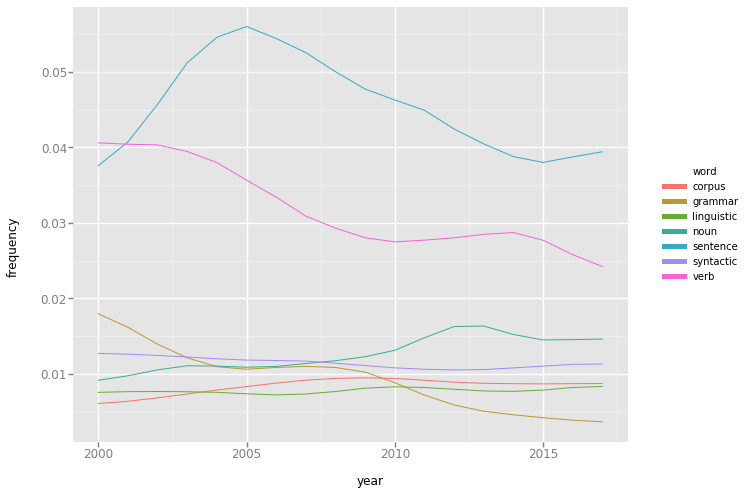

<ggplot: (312216054)>
Topic Number: 15


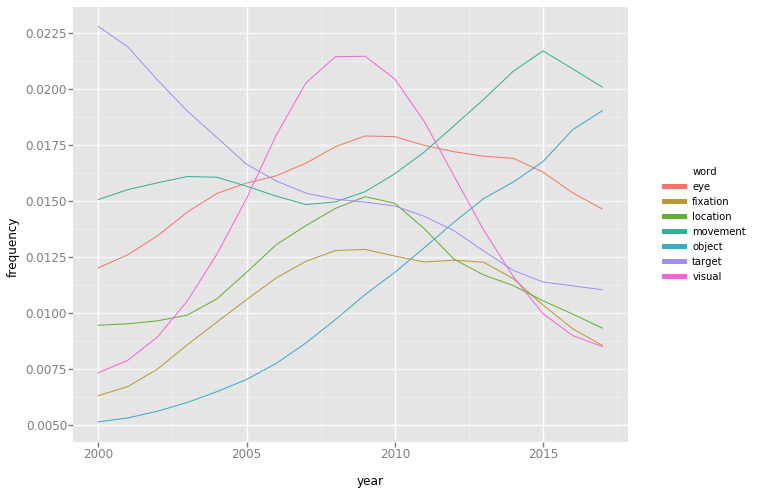

<ggplot: (-9223372036542550475)>
Topic Number: 16


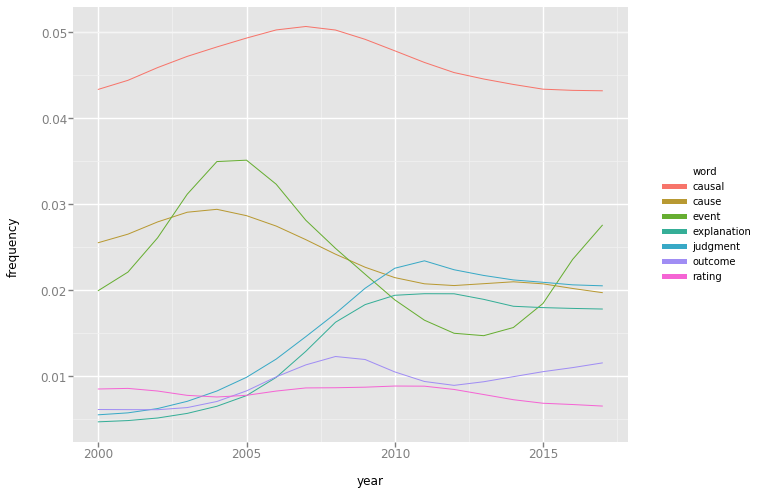

<ggplot: (312216012)>
Topic Number: 17


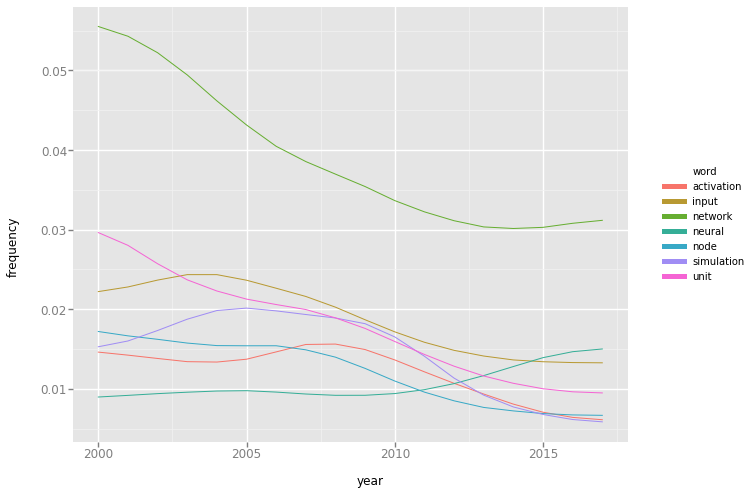

<ggplot: (312441096)>
Topic Number: 18


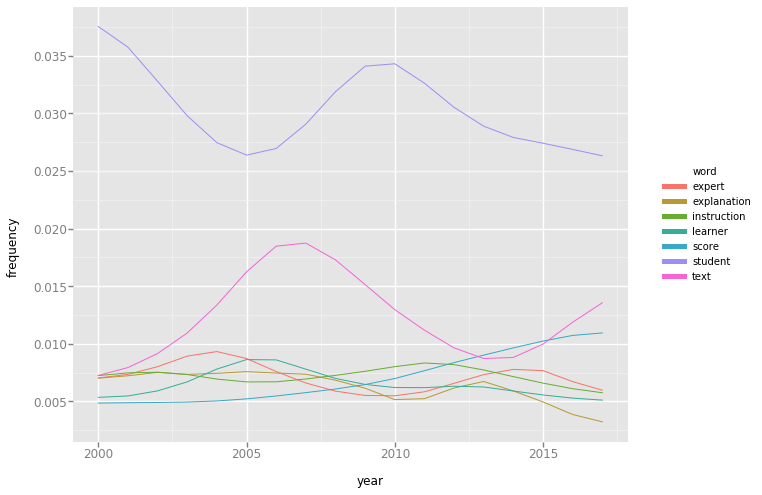

<ggplot: (-9223372036542550356)>
Topic Number: 19


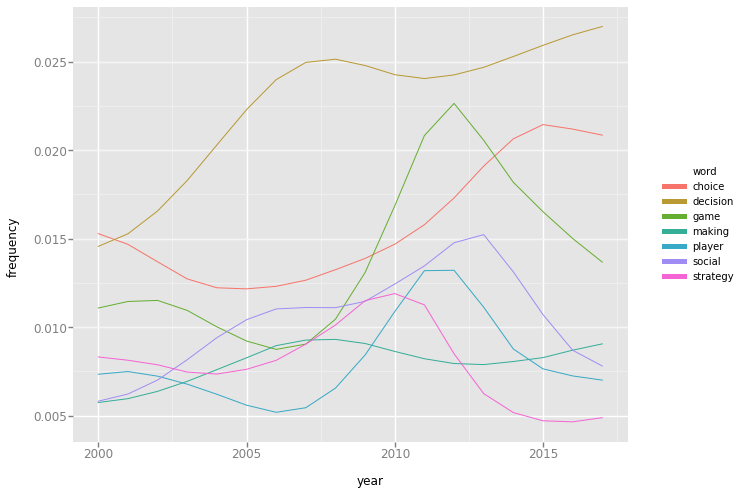

<ggplot: (-9223372036542550321)>


In [74]:
for i, g in enumerate(graphs):
    print('Topic Number:', i)
    print(g)